In [1]:
# !pip install numpy --upgrade

In [2]:
from time import time
import warnings
warnings.simplefilter(action='ignore',)

from pylab import cm
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt

from qiskit.algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector
quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'), shots=128)

import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVC
sns.set_style("darkgrid")

from utils import train_test_split, QKTCallback

In [3]:
DATA_FILEPATH = "dataset_graph7.csv"
X_train, y_train, X_test, y_test = train_test_split(DATA_FILEPATH)

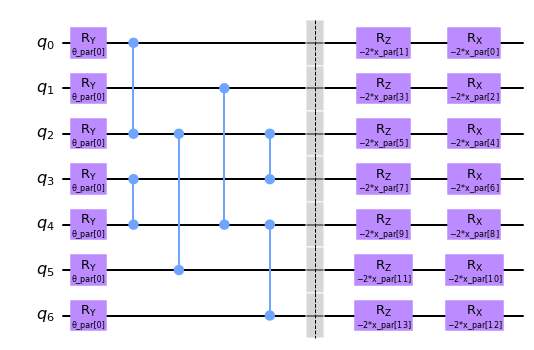

In [4]:
c_qc = QuantumCircuit(7)
c_x = ParameterVector('x_par', 14)  
user_params = ParameterVector("θ_par",1)

c_qc.ry(user_params[0],range(7))

entangle_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
for i in range(len(entangle_map)):
    c_qc.cz(int(entangle_map[i][0]),int(entangle_map[i][1]))

c_qc.barrier()

for i in range(7):
    
    c_qc.rz(-2*c_x[2*i+1],i)
    c_qc.rx(-2*c_x[2*i],i)

c_qc.draw(output="mpl")

In [5]:
ITER = 10

quant_kernel = QuantumKernel(
    c_qc, user_parameters=user_params, quantum_instance=quantum_instance)

cb_qkt = QKTCallback()

spsa_opt = SPSA(
    maxiter=ITER, 
    callback=cb_qkt.callback, 
    learning_rate=0.1, 
    perturbation=0.1)


qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel,
    loss="svc_loss",
    optimizer=spsa_opt,
    initial_point=[0.1] *1) # parameter個數

In [6]:
start_time = time()
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
end_time = time()
print("cost time:",end_time-start_time)

cost time: 8.111372232437134


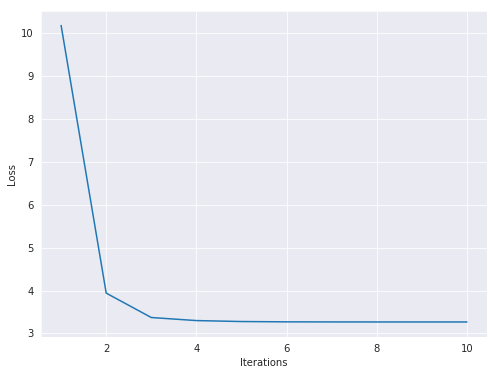

In [7]:
plt.figure(figsize=(8,6))
plot_data = cb_qkt.get_callback_data()
sns.set_style("darkgrid")
plt.plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]))
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [8]:
qka_results.optimal_parameters

{ParameterVectorElement(θ_par[0]): 1.76245545541508}

In [9]:
model = SVC(kernel=optimized_kernel.evaluate)
qsvm = model.fit(X_train, y_train)
q_score = model.score(X_test, y_test)
print(f'Covariant kernel acc: {q_score}')

Covariant kernel acc: 1.0
